## DRACH Motifs

In [11]:
# Define the possible nucleotides for each position
D = ['A', 'G', 'T']
R = ['A', 'G']
A = ['A']
C = ['C']
H = ['A', 'C', 'T']

# Initialize an empty list to store the DRACH motifs
drach_motifs = []

# Generate all combinations using nested loops
for d in D:
    for r in R: 
        for a in A:
            for c in C:
                for h in H:
                    motif = d + r + a + c + h
                    drach_motifs.append(motif)

# Print the list of DRACH motifs
print(drach_motifs)

['AAACA', 'AAACC', 'AAACT', 'AGACA', 'AGACC', 'AGACT', 'GAACA', 'GAACC', 'GAACT', 'GGACA', 'GGACC', 'GGACT', 'TAACA', 'TAACC', 'TAACT', 'TGACA', 'TGACC', 'TGACT']


## Loading The Data

In [12]:
import gzip
import json
import pandas as pd

### `datasetx.json.gz`

In [20]:
# Function to load data.json.gz file as dataframe
def load_json_gz_to_dataframe(file_path, num_lines=0):
    '''
    If num_lines <= 0, read all lines.
    Else, read until specified number of lines.
    '''
    data = []
    with gzip.open(file_path) as f:
        for i, line in enumerate(f, start=1):
            if num_lines > 0 and i > num_lines:
                break
            json_data = json.loads(line)
            for transcript, positions in json_data.items():
                for position, sequences in positions.items():
                    position = int(position)
                    for sequence, reads in sequences.items():
                        data.append({
                            'transcript_id': transcript,
                            'position': position,
                            'sequence': sequence,
                            "data" : reads
                            })
    return pd.DataFrame(data)

In [8]:
# Load the data
# dataset0: 121838 lines
# dataset1: 90810 lines
# dataset2: 1323 lines
file_path = 'data/dataset0.json.gz'
dataset_20lines = load_json_gz_to_dataframe(file_path, 20)
dataset_20lines.head(3)

### `data.info.labelled`

In [14]:
# Load labels
labels = pd.read_csv('data.info.labelled')
labels.head(3)

,gene_id,transcript_id,transcript_position,label
0,ENSG00000004059,ENST00000000233,244,0
1,ENSG00000004059,ENST00000000233,261,0
2,ENSG00000004059,ENST00000000233,316,0


## Baseline Model: Logistic Regression

### Exploratory Data Analysis

In [15]:
import numpy as np
from matplotlib import pyplot as plt

In [16]:
# Helper function
def extractSequences(sequence):
    '''
    Returns the left, middle and right of a given sequence
    '''
    out = []
    for i in range(3):
        out.append(sequence[i:(i+5)])
    return out

In [ ]:
# Number of reads at each position for every transcript
num_reads = dataset_20lines.groupby(['transcript_id', 'position', 'sequence']).size().reset_index(name='count')
num_reads.head(3)

,transcript_id,position,sequence,count
0,ENST00000000233,244,AAGACCA,185
1,ENST00000000233,261,CAAACTG,172
2,ENST00000000233,316,GAAACAG,185


In [94]:
# Proportion of positive labels
np.mean(labels['label'] == 1)

0.044936719250151844

### Feature Engineering & Pre-processing

In [17]:
from sklearn.model_selection import train_test_split

In [21]:
# Load full dataset
file_path = 'dataset0.json.gz'
dataset = load_json_gz_to_dataframe(file_path)

In [22]:
dataset

,transcript_id,position,sequence,data
0,ENST00000000233,244,AAGACCA,"[[0.00299, 2.06, 125.0, 0.0177, 10.4, 122.0, 0..."
1,ENST00000000233,261,CAAACTG,"[[0.0126, 1.95, 111.0, 0.0125, 1.27, 108.0, 0...."
2,ENST00000000233,316,GAAACAG,"[[0.00432, 2.02, 104.0, 0.00299, 3.56, 99.3, 0..."
3,ENST00000000233,332,AGAACAT,"[[0.0134, 4.71, 132.0, 0.00447, 4.24, 98.8, 0...."
4,ENST00000000233,368,AGGACAA,"[[0.015, 6.97, 118.0, 0.0106, 3.04, 123.0, 0.0..."
...,...,...,...,...
121833,ENST00000641834,1348,GGGACAT,"[[0.0112, 2.96, 116.0, 0.0093, 3.24, 115.0, 0...."
121834,ENST00000641834,1429,CTGACAC,"[[0.00697, 4.25, 112.0, 0.00481, 8.67, 119.0, ..."
121835,ENST00000641834,1531,TGGACAC,"[[0.00996, 3.12, 112.0, 0.00432, 4.5, 115.0, 0..."
121836,ENST00000641834,1537,CTGACCA,"[[0.00396, 3.14, 108.0, 0.00747, 5.79, 125.0, ..."


In [25]:
# Take the mean of the reads
dataset["data"] = dataset['data'].apply(lambda x: np.mean(x, axis=0))

In [27]:
# Inner join df on labels
merged_df = pd.merge(dataset, labels,
                     left_on  = ['transcript_id', 'position'],
                     right_on = ['transcript_id', 'transcript_position'],
                     how = 'left')
tmp = merged_df['gene_id']
merged_df = merged_df.drop(columns=['transcript_position', 'gene_id'])
merged_df.insert(0, 'gene_id', tmp)

merged_df.head(3)

,gene_id,transcript_id,position,sequence,data,label
0,ENSG00000004059,ENST00000000233,244,AAGACCA,"[0.008264378378378385, 4.223783783783786, 123....",0
1,ENSG00000004059,ENST00000000233,261,CAAACTG,"[0.006609244186046515, 3.2164244186046504, 109...",0
2,ENSG00000004059,ENST00000000233,316,GAAACAG,"[0.0075699999999999995, 2.94054054054054, 105....",0


In [28]:
# Proportion of positive labels in merged_df
np.mean([merged_df['label'] == 1])

0.044936719250151844

In [147]:
# Train-test split by gene_id
unique_genes = labels['gene_id'].unique()
train_genes, test_genes = train_test_split(unique_genes, test_size=0.3, random_state=42)

train_df = merged_df[merged_df['gene_id'].isin(train_genes)]
test_df  = merged_df[merged_df['gene_id'].isin(test_genes)]

X_train = train_df.drop(columns=['gene_id', 'transcript_id', 'position', 'label'])
y_train = train_df[['label']]
X_test = test_df.drop(columns=['gene_id', 'transcript_id', 'position', 'label'])
y_test = test_df[['label']]

### Model Training

In [148]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve

In [149]:
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

c:\Users\hongl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hongl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Model Validation

In [150]:
# Get the class prediction
y_pred = log_reg_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.9587285380336943
Confusion Matrix:
[[35681     0]
 [ 1536     0]]


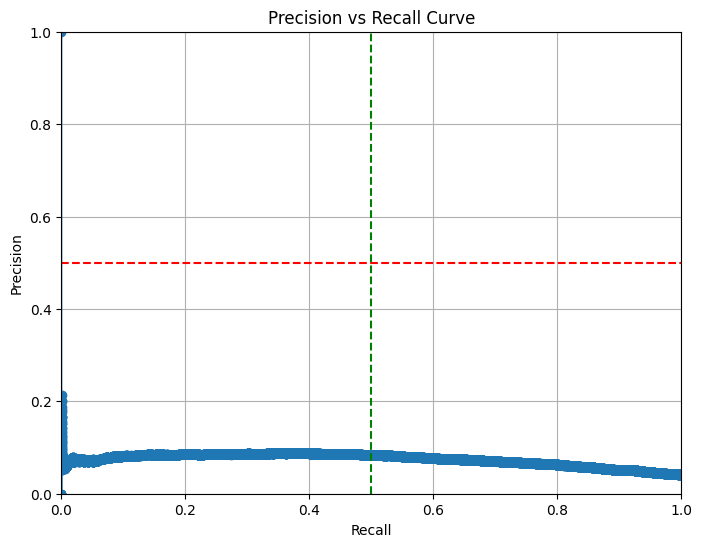

In [151]:
# Get the probabilities for the positive class
y_scores = log_reg_model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='o')
plt.title('Precision vs Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.axhline(y=0.5, color='r', linestyle='--')  # Reference line for 0.5 precision
plt.axvline(x=0.5, color='g', linestyle='--')  # Reference line for 0.5 recall
plt.show()

### Synthetic Minority Over-sampling Technique (SMOTE)

c:\Users\hongl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.6202541849154956
Confusion Matrix:
[[22058 13623]
 [  510  1026]]


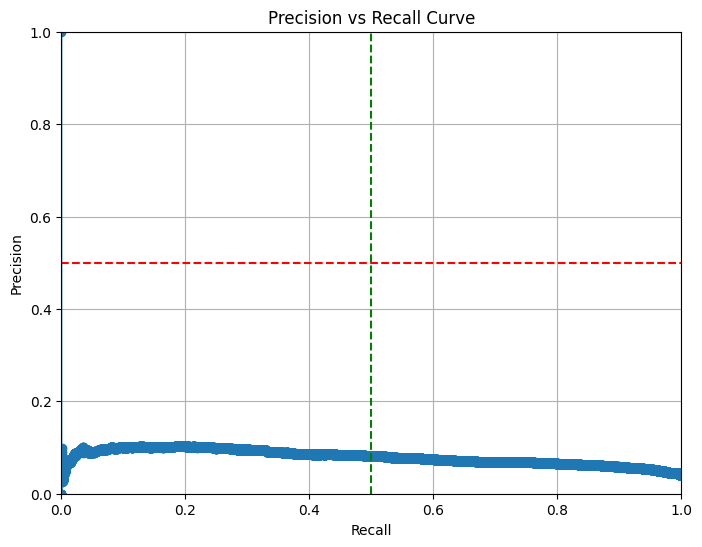

In [152]:
from imblearn.over_sampling import SMOTE

# Simulate data with label 1 using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# New fit
log_reg_model2 = LogisticRegression()
log_reg_model2.fit(X_resampled, y_resampled)


# Get the class prediction
y_pred = log_reg_model2.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion)

# Get the probabilities for the positive class
y_scores = log_reg_model2.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='o')
plt.title('Precision vs Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.axhline(y=0.5, color='r', linestyle='--')  # Reference line for 0.5 precision
plt.axvline(x=0.5, color='g', linestyle='--')  # Reference line for 0.5 recall
plt.show()

In [163]:
dataset['sequence'].apply(extractSequences)

0           [AAGAC, AGACC, GACCA]
1           [AAGAC, AGACC, GACCA]
2           [AAGAC, AGACC, GACCA]
3           [AAGAC, AGACC, GACCA]
4           [AAGAC, AGACC, GACCA]
                    ...          
11027101    [TTGAC, TGACA, GACAT]
11027102    [TTGAC, TGACA, GACAT]
11027103    [TTGAC, TGACA, GACAT]
11027104    [TTGAC, TGACA, GACAT]
11027105    [TTGAC, TGACA, GACAT]
Name: sequence, Length: 11027106, dtype: object

## Advanced Model: Some neural network

### Feature Engineering & Pre-processing

In [ ]:
# Train-test split

### Model Training

### Model Validation

### Model Prediction